# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [2]:
%%time
storage = paths.AnalysisStorage("ala_mstis_production.nc")

CPU times: user 48.1 s, sys: 2.36 s, total: 50.5 s
Wall time: 50.6 s


In [3]:
print("PathMovers:", len(storage.pathmovers))
print("Engines:", len(storage.engines))
print("Samples:", len(storage.samples))
print("Ensembles:", len(storage.ensembles))
print("SampleSets:", len(storage.samplesets))
print("Snapshots:", len(storage.snapshots))
print("Trajectories:", len(storage.trajectories))
print("Networks:", len(storage.networks))

PathMovers: 125
Engines: 3
Samples: 13122
Ensembles: 315
SampleSets: 10001
Snapshots: 436772
Trajectories: 8000
Networks: 1


In [4]:
%%time
mstis = storage.networks[0]

CPU times: user 16 µs, sys: 1 µs, total: 17 µs
Wall time: 19.3 µs


In [5]:
%%time
for cv in storage.cvs:
    print(cv.name, cv._store_dict)

opA None
phi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7a591fda0>
psi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7a5dc1f60>
opB None
opC None
opD None
max opD <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7ade02828>
max opB <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7a6b057b8>
max opC <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7a56bbf60>
max opA <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7a5ea0438>
opE None
opF None
max opE <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7a5597048>
max opF <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7fa7a6b059b0>
CPU times: user 1.5 ms, sys: 26 µs, total: 1.53 ms
Wall time: 1.22 ms


## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [6]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 2, 'bin_range' : (0.0, 90) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 100) }

In [7]:
%%time
mstis.rate_matrix(storage.steps, force=True)

/faststore/homedirs/dswenso1/openpathsampling/openpathsampling/high_level/network.py:616: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  rate)


CPU times: user 21.6 s, sys: 378 ms, total: 22 s
Wall time: 21.8 s


,A,B,C,D
A,NaN,0.0628570742364 /ps,0.00136010659111 /ps,0.00485608427343 /ps
B,0.148157338922 /ps,NaN,0.0 /ps,0.000799122647909 /ps
C,0.0730391994665 /ps,0.0159285487056 /ps,NaN,0.197946235924 /ps
D,0.00648869347808 /ps,0.0110497834543 /ps,0.048081490166 /ps,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [8]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

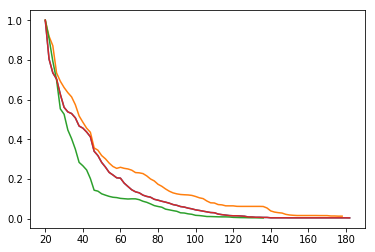

In [9]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

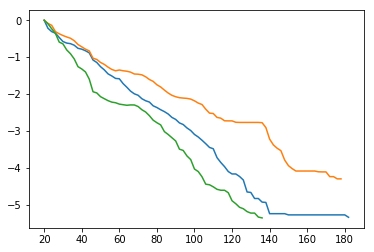

In [10]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [11]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

/home/dswenso1/miniconda2/envs/ops_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


,"{x|opA(x) in [0, 10]}","{x|opB(x) in [0, 10]}","{x|opC(x) in [0, 10]}","{x|opD(x) in [0, 10]}"
"{x|opA(x) in [0, 10]}",NaN,1.07205623902 /ps,1.07205623902 /ps,1.07205623902 /ps
"{x|opB(x) in [0, 10]}",2.23880597015 /ps,NaN,2.23880597015 /ps,2.23880597015 /ps
"{x|opC(x) in [0, 10]}",1.54169586545 /ps,1.54169586545 /ps,NaN,1.54169586545 /ps
"{x|opD(x) in [0, 10]}",2.74068868587 /ps,2.74068868587 /ps,2.74068868587 /ps,NaN


### Conditional transition probability

In [12]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

/home/dswenso1/miniconda2/envs/ops_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


,"{x|opA(x) in [0, 10]}","{x|opB(x) in [0, 10]}","{x|opC(x) in [0, 10]}","{x|opD(x) in [0, 10]}"
"{x|opA(x) in [0, 10]}",NaN,0.623838,0.0134987,0.0481952
"{x|opB(x) in [0, 10]}",0.834217,NaN,0,0.00449955
"{x|opC(x) in [0, 10]}",0.182482,0.039796,NaN,0.494551
"{x|opD(x) in [0, 10]}",0.0477952,0.0813919,0.354165,NaN


## Path ensemble properties

In [13]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

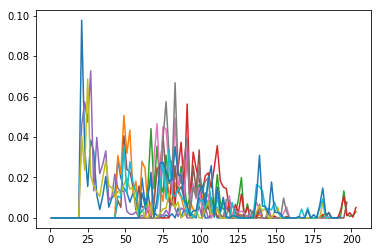

In [14]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [15]:
# add visualization of the sum

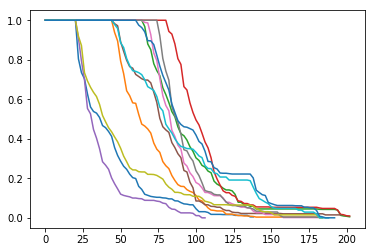

In [16]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

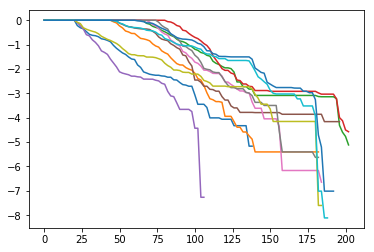

In [17]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

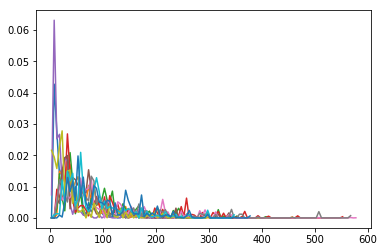

In [18]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

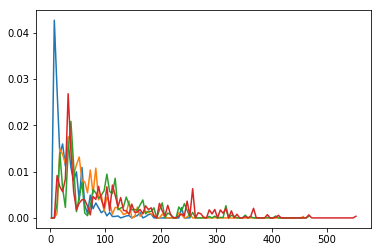

In [19]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [20]:
scheme = storage.schemes[0]

In [21]:
scheme.move_summary(storage.steps)

repex ran 22.760% (expected 23.10%) of the cycles with acceptance 956/2276 (42.00%)
shooting ran 45.950% (expected 46.20%) of the cycles with acceptance 3222/4595 (70.12%)
pathreversal ran 25.080% (expected 24.75%) of the cycles with acceptance 1510/2508 (60.21%)
minus ran 2.850% (expected 2.64%) of the cycles with acceptance 243/285 (85.26%)
ms_outer_shooting ran 3.360% (expected 3.30%) of the cycles with acceptance 210/336 (62.50%)


In [22]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out A 0 ran 3.500% (expected 3.30%) of the cycles with acceptance 278/350 (79.43%)
OneWayShootingMover Out A 1 ran 3.580% (expected 3.30%) of the cycles with acceptance 261/358 (72.91%)
OneWayShootingMover Out A 2 ran 3.150% (expected 3.30%) of the cycles with acceptance 196/315 (62.22%)
OneWayShootingMover Out A 3 ran 3.410% (expected 3.30%) of the cycles with acceptance 197/341 (57.77%)
OneWayShootingMover Out B 0 ran 3.030% (expected 3.30%) of the cycles with acceptance 261/303 (86.14%)
OneWayShootingMover Out B 1 ran 3.470% (expected 3.30%) of the cycles with acceptance 242/347 (69.74%)
OneWayShootingMover Out B 2 ran 3.100% (expected 3.30%) of the cycles with acceptance 210/310 (67.74%)
OneWayShootingMover Out B 3 ran 3.340% (expected 3.30%) of the cycles with acceptance 200/334 (59.88%)
OneWayShootingMover Out C 0 ran 3.130% (expected 3.30%) of the cycles with acceptance 240/313 (76.68%)
OneWayShootingMover Out C 1 ran 3.080% (expected 3.30%) of the cycles wit

In [23]:
scheme.move_summary(storage.steps, 'minus')

Minus ran 0.690% (expected 0.66%) of the cycles with acceptance 61/69 (88.41%)
Minus ran 0.630% (expected 0.66%) of the cycles with acceptance 60/63 (95.24%)
Minus ran 0.720% (expected 0.66%) of the cycles with acceptance 44/72 (61.11%)
Minus ran 0.810% (expected 0.66%) of the cycles with acceptance 78/81 (96.30%)


In [24]:
scheme.move_summary(storage.steps, 'repex')

ReplicaExchange ran 1.470% (expected 1.65%) of the cycles with acceptance 56/147 (38.10%)
ReplicaExchange ran 1.610% (expected 1.65%) of the cycles with acceptance 79/161 (49.07%)
ReplicaExchange ran 1.650% (expected 1.65%) of the cycles with acceptance 102/165 (61.82%)
ReplicaExchange ran 1.520% (expected 1.65%) of the cycles with acceptance 31/152 (20.39%)
ReplicaExchange ran 1.590% (expected 1.65%) of the cycles with acceptance 117/159 (73.58%)
ReplicaExchange ran 1.690% (expected 1.65%) of the cycles with acceptance 118/169 (69.82%)
ReplicaExchange ran 1.470% (expected 1.65%) of the cycles with acceptance 60/147 (40.82%)
ReplicaExchange ran 1.930% (expected 1.65%) of the cycles with acceptance 148/193 (76.68%)
ReplicaExchange ran 1.450% (expected 1.65%) of the cycles with acceptance 17/145 (11.72%)
ReplicaExchange ran 1.640% (expected 1.65%) of the cycles with acceptance 78/164 (47.56%)
ReplicaExchange ran 1.660% (expected 1.65%) of the cycles with acceptance 70/166 (42.17%)
Replic

In [25]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 1.820% (expected 1.65%) of the cycles with acceptance 173/182 (95.05%)
PathReversal ran 1.620% (expected 1.65%) of the cycles with acceptance 116/162 (71.60%)
PathReversal ran 1.820% (expected 1.65%) of the cycles with acceptance 92/182 (50.55%)
PathReversal ran 1.650% (expected 1.65%) of the cycles with acceptance 56/165 (33.94%)
PathReversal ran 1.540% (expected 1.65%) of the cycles with acceptance 141/154 (91.56%)
PathReversal ran 1.930% (expected 1.65%) of the cycles with acceptance 90/193 (46.63%)
PathReversal ran 1.640% (expected 1.65%) of the cycles with acceptance 49/164 (29.88%)
PathReversal ran 1.580% (expected 1.65%) of the cycles with acceptance 29/158 (18.35%)
PathReversal ran 1.700% (expected 1.65%) of the cycles with acceptance 138/170 (81.18%)
PathReversal ran 1.690% (expected 1.65%) of the cycles with acceptance 84/169 (49.70%)
PathReversal ran 1.510% (expected 1.65%) of the cycles with acceptance 50/151 (33.11%)
PathReversal ran 1.910% (expected 1.65%

### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [26]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

#### Replica exchange mixing matrix

In [27]:
repx_net.mixing_matrix()

,15,14,17,4,0,11,5,1,12,6,2,13,7,3,18,10,9,8,16
15,0.000000,0.000000,0.000000,0.023428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.023819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.000000,0.000000,0.000000,0.000000,0.000000,0.030457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.023428,0.000000,0.000000,0.000000,0.000000,0.000000,0.012105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.023819,0.000000,0.000000,0.000000,0.000000,0.000000,0.021866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.030457,0.000000,0.000000,0.000000,0.000000,0.000000,0.006638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.012105,0.000000,0.000000,0.000000,0.000000,0.000000,0.045685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.021866,0.000000,0.000000,0.000000,0.000000,0.000000,0.030847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.006638,0.000000,0.000000,0.000000,0.000000,0.000000,0.030457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045685,0.000000,0.000000,0.000000,0.000000,0.000000,0.046076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

/home/dswenso1/miniconda2/envs/ops_py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


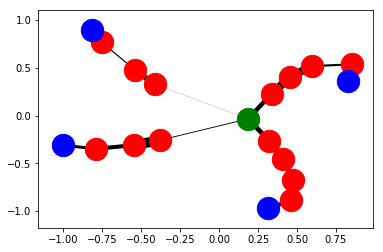

In [28]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [29]:
import openpathsampling.visualize as vis
#reload(vis)
from IPython.display import SVG

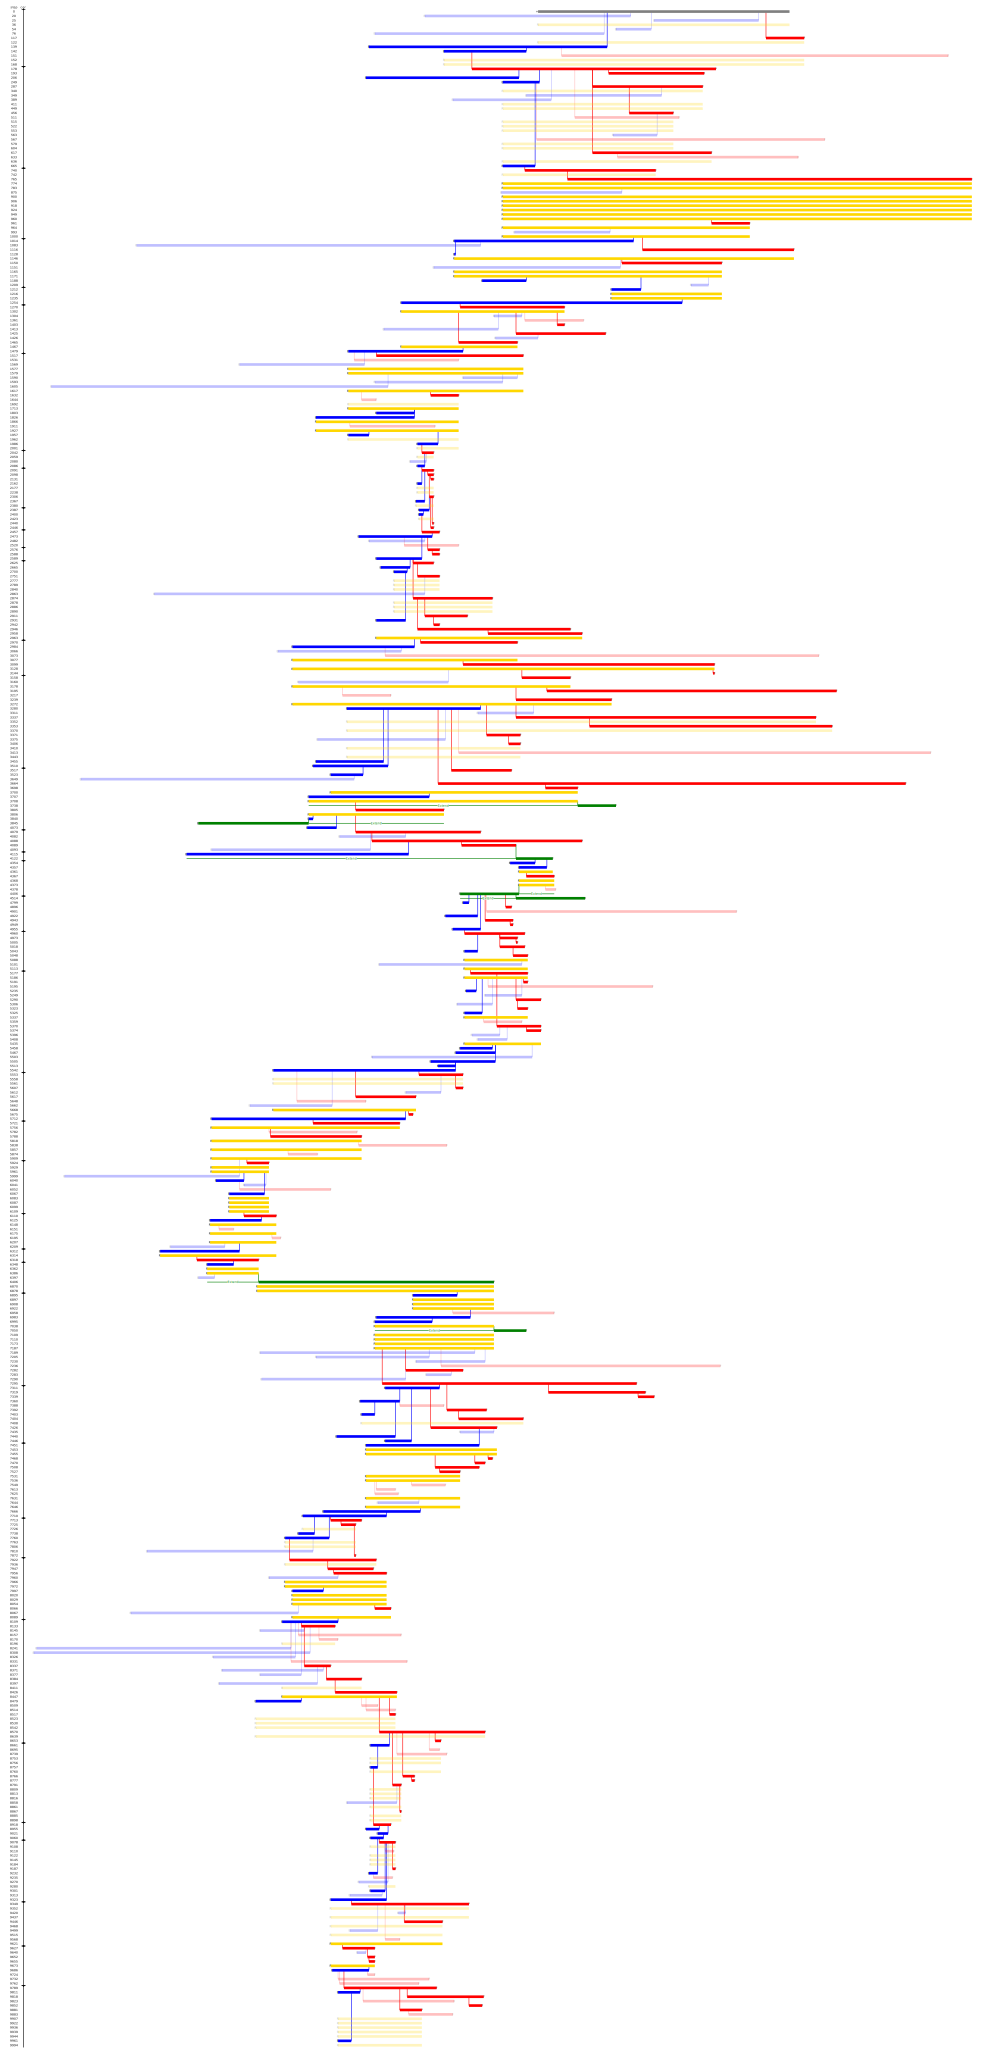

In [30]:
tree = vis.PathTree(
    [step for step in storage.steps if not isinstance(step.change, paths.EmptyMoveChange)],
    vis.ReplicaEvolution(replica=3, accepted=False)
)
tree.options.css['width'] = 'inherit'

SVG(tree.svg())

In [32]:
decorrelated = tree.generator.decorrelated
print ("We have " + str(len(decorrelated)) + " decorrelated trajectories.")

We have 40 decorrelated trajectories.


### Visualizing trajectories

## Histogramming data (TODO)